<a href="https://colab.research.google.com/github/sushi15/Fashion-MNIST/blob/main/pre_trained_fashionMNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports 

In [ ]:
import itertools
import os

import matplotlib.pylab as plt 
%matplotlib inline 
from matplotlib import pyplot
import numpy as np 

import tensorflow as tf
import tensorflow_hub as hub 
from tensorflow.keras.utils import to_categorical 
from tensorflow.keras.callbacks import ModelCheckpoint 

import keras 
from keras.applications.vgg16 import preprocess_input 
from keras.preprocessing.image import img_to_array, array_to_img 
from keras.layers import Dense, Dropout, Flatten
from keras.models import Model
from keras import models
from keras import layers
from keras import optimizers

import random

from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# Tensorflow Dataset Selection

In [ ]:
hw = 70
prmodel = tf.keras.applications.VGG16(
    include_top = False,
    weights = "imagenet",
    input_shape = (hw, hw, 3), 
    classes = 10,
)

prmodel.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 70, 70, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 70, 70, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 70, 70, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 35, 35, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 35, 35, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 35, 35, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 17, 17, 128)       0     

In [ ]:
BATCH_SIZE = 256 #@param {type:"slider", min:0, max:256, step:2}

In [ ]:
EPOCH_SIZE = 47 #@param {type:"integer"}

# Load Fashion MNIST

In [ ]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

In [ ]:
assert x_train.shape == (60000, 28, 28)
assert x_test.shape == (10000, 28, 28)
assert y_train.shape == (60000,)
assert y_test.shape == (10000,)

0


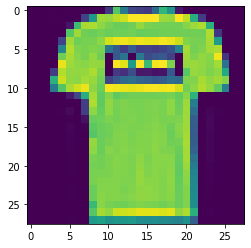

In [ ]:
# Test - Not required 
plt.imshow(x_train[1]) 
print(y_train[1])

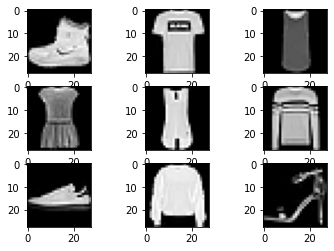

In [ ]:
# Test - Not required 
for i in range(9):
	pyplot.subplot(330 + 1 + i)
	pyplot.imshow(x_train[i], cmap=pyplot.get_cmap('gray'))
pyplot.show()

# Data Preprocessing

Reshaping features, images required to be in RGB with 3 channels

In [ ]:
x_train = np.dstack([x_train] * 3)
x_test = np.dstack([x_test] * 3)
x_train = x_train.reshape(-1, 28,28,3)
x_test= x_test.reshape (-1,28,28,3)

# x_train = x_train.reshape((x_train.shape[0], 28, 28, 1))
# x_test = x_test.reshape((x_test.shape[0], 28, 28, 1)) 
print(x_train.shape) 
print(x_test.shape)

(60000, 28, 28, 3)
(10000, 28, 28, 3)


Resize images as minimum height and width should be 32/48 for VGG16/VGG19 respectively

In [ ]:
x_train = np.asarray([img_to_array(array_to_img(im, scale = False).resize((hw, hw))) for im in x_train])
x_test = np.asarray([img_to_array(array_to_img(im, scale = False).resize((hw, hw))) for im in x_test]) 

# Setting hw to >70 caused Colab to crash 
# Greater height/width value preferred 

print(x_train.shape) 
print(x_test.shape)

(60000, 70, 70, 3)
(10000, 70, 70, 3)


Rescale values to range [0, 1]

In [ ]:
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

x_train = x_train / 255.0
x_test = x_test / 255.0

Reshape labels first to (n, 1) i.e. 1D to 2D then preprocess labels using one-hot encoding

In [ ]:
y_train = y_train.reshape(60000, 1) 
y_test = y_test.reshape(10000, 1)
# print(y_test.shape) 
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [ ]:
# Test - Not required 
y_train[50000:50010, :] # Some y_train values before split that should be the same as the first 10 y_val values

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)

Split training sets into training and validation sets

In [ ]:
training_set_size = 48000 #@param {type:"slider", min:0, max:60000, step:1000}
x_val = x_train[training_set_size:, :]
x_train = x_train[:training_set_size, :] 
y_val = y_train[training_set_size:, :] 
y_train = y_train[:training_set_size, :] 

print(x_val.shape) 
print(x_train.shape)
print(y_val.shape) 
print(y_train.shape)

(12000, 70, 70, 3)
(48000, 70, 70, 3)
(12000, 10)
(48000, 10)


In [ ]:
# Test - Not required 
y_val[:10, :] #Test y_val values after split

array([[0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)

Augmentation

In [ ]:
gen = tf.keras.preprocessing.image.ImageDataGenerator(rotation_range=8, width_shift_range=0.08, shear_range=0.3,
                               height_shift_range=0.08, zoom_range=0.08)

In [ ]:
x_train = preprocess_input(x_train)
x_val = preprocess_input(x_val)
x_test = preprocess_input(x_test)

# Feature extraction using the pretrained model 'prmodel' with predefined batch size

In [ ]:
f_train = prmodel.predict(np.array(x_train), batch_size = BATCH_SIZE, verbose = 1)
f_val = prmodel.predict(np.array(x_val), batch_size = BATCH_SIZE, verbose = 1) 

47/47 [==============================] - 9s 202ms/step


In [ ]:
np.savez("f_train", f_train, y_train)
np.savez("f_val", f_val, y_val) 

In [ ]:
size = f_train.shape[1] * f_train.shape[2] * f_train.shape[3] 
f_train = np.reshape(f_train, (f_train.shape[0], size))
f_val = np.reshape(f_val, (f_val.shape[0], size)) 

# Defining the last layers of the model that go above the pretrained model

In [ ]:
model = models.Sequential()
model.add(layers.Dense(512, activation = 'relu', input_dim = size))
model.add(layers.Dropout(0.3)) 
# model.add(layers.Flatten())
# model.add(layers.Dense(256, activation = 'relu'))
model.add(layers.Dense(10, activation = "softmax"))

In [ ]:
model.compile(loss = keras.losses.categorical_crossentropy,
              optimizer = keras.optimizers.Adam(),
              metrics = ['accuracy'])

# Checkpoints

In [ ]:
checkpoint_path = '/content/gdrive/My Drive/CNNs/pretrained/cp-{epoch:04d}.ckpt'
checkpoint_dir = os.path.dirname(checkpoint_path)

cp_callback = ModelCheckpoint(
    filepath = checkpoint_path, 
    verbose = 1, 
    save_weights_only = True,
    period = 1)

Reloading weights

In [ ]:
# model.load_weights('/content/gdrive/My Drive/CNNs/pretrained/cp-0024.ckpt') 

# Training

In [ ]:
history = model.fit(f_train, 
                    y_train, 
                    # steps_per_epoch = y_train.shape[0] // BATCH_SIZE, 
                    batch_size = BATCH_SIZE, 
                    epochs = EPOCH_SIZE, 
                    verbose = 1, 
                    validation_data = (f_val, y_val), 
                    callbacks=[cp_callback] 
                    ) 

Epoch 1/47
188/188 [==============================] - 13s 6ms/step - loss: 2.9653 - accuracy: 0.2117 - val_loss: 1.5580 - val_accuracy: 0.4530

Epoch 00001: saving model to /content/gdrive/My Drive/CNNs/pretrained/cp-0001.ckpt
Epoch 2/47
188/188 [==============================] - 1s 5ms/step - loss: 1.5342 - accuracy: 0.4442 - val_loss: 1.2767 - val_accuracy: 0.5547

Epoch 00002: saving model to /content/gdrive/My Drive/CNNs/pretrained/cp-0002.ckpt
Epoch 3/47
188/188 [==============================] - 1s 5ms/step - loss: 1.2982 - accuracy: 0.5331 - val_loss: 1.1674 - val_accuracy: 0.6079

Epoch 00003: saving model to /content/gdrive/My Drive/CNNs/pretrained/cp-0003.ckpt
Epoch 4/47
188/188 [==============================] - 1s 5ms/step - loss: 1.1870 - accuracy: 0.5698 - val_loss: 1.1092 - val_accuracy: 0.5915

Epoch 00004: saving model to /content/gdrive/My Drive/CNNs/pretrained/cp-0004.ckpt
Epoch 5/47
188/188 [==============================] - 1s 5ms/step - loss: 1.1137 - accuracy: 0.

# Analysis

Feature Extraction run on test set

In [ ]:
f_test = prmodel.predict(np.array(x_test), batch_size = BATCH_SIZE, verbose = 1) 
np.savez("f_test", f_test, y_test) 
f_test = np.reshape(f_test, (f_test.shape[0], size)) 

40/40 [==============================] - 5s 118ms/step


In [ ]:
score = model.evaluate(f_test, y_test, verbose=0)
print('Loss on running test : ', score[0])
print('Accuracy on running test : ', score[1])

Loss on running test :  0.7660725712776184
Accuracy on running test :  0.7239999771118164


In [ ]:
# x_train.shape[0], BATCH_SIZE, EPOCH_SIZE, hw, VGG code, No. of additional layers -> Test set accuracy 
# 48000, 64, 40, 48, 16, 3 -> 0.722
# 48000, 64, 30, 48, 16, 3 -> 0.725
# 48000, 256, 50, 60, 16, 3 -> 0.729
# 48000, 128, 50, 70, 16, 3 -> 0.70 
# 48000, 256, 47, 70, 16, 3, -> 0.737 - Highest accuracy achieved

# VGG19 seemed to give the same or worse results than VGG16 

# Plots

In [ ]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


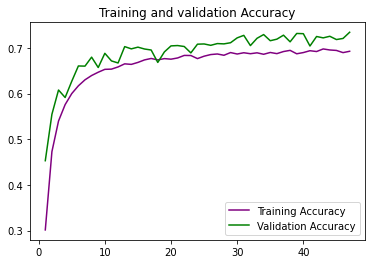

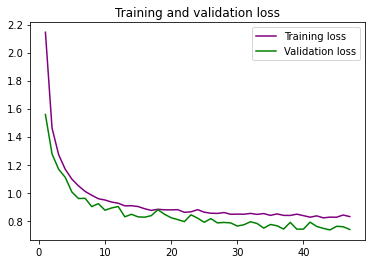

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.title('Training and validation Accuracy')
plt.plot(epochs, acc, 'purple', label='Training Accuracy')
plt.plot(epochs, val_acc, 'green', label = 'Validation Accuracy')
plt.legend()

plt.figure()
plt.title('Training and validation loss')
plt.plot(epochs, loss, 'purple', label = 'Training loss')
plt.plot(epochs, val_loss, 'green', label = 'Validation loss')

plt.legend()

plt.show()